In [ ]:
! pip install fedimpute==0.1.0
! pip install tabulate matplotlib numpy pandas

In [2]:
import numpy as np
import pandas as pd
import tabulate
import matplotlib.pyplot as plt

plt.rc('font', family='arial')
plt.rc('pdf', fonttype = 42)
plt.rc('ps', fonttype = 42)

# Load Data

In [3]:
%load_ext autoreload
%autoreload 2

from fedimpute.data_prep import load_data, display_data
data, data_config = load_data("codrna")
display_data(data)
print("Data Dimensions: ", data.shape)
print("Data Config:\n", data_config)

+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|   X1   |   X2   |   X3   |   X4   |   X5   |   X6   |   X7   |   X8   |   y    |
|--------+--------+--------+--------+--------+--------+--------+--------+--------|
| 0.7554 | 0.1364 | 0.0352 | 0.4132 | 0.6937 | 0.1591 | 0.3329 | 0.7154 | 1.0000 |
| 0.7334 | 0.7879 | 0.3819 | 0.3693 | 0.5619 | 0.4830 | 0.4351 | 0.5160 | 0.0000 |
| 0.7752 | 0.1364 | 0.1761 | 0.3290 | 0.7410 | 0.4259 | 0.4644 | 0.5268 | 1.0000 |
| 0.5905 | 0.7424 | 0.2720 | 0.2898 | 0.6920 | 0.3205 | 0.4019 | 0.6290 | 1.0000 |
| 0.7366 | 0.1212 | 0.2465 | 0.3290 | 0.7410 | 0.3249 | 0.5086 | 0.5631 | 1.0000 |
+--------+--------+--------+--------+--------+--------+--------+--------+--------+
Data Dimensions:  (5000, 9)
Data Config:
 {'target': 'y', 'task_type': 'classification', 'natural_partition': False}


# Scenario Simulation

## Basic Usage

In [10]:
%load_ext autoreload
%autoreload 2
from fedimpute.scenario import ScenarioBuilder

scenario_builder = ScenarioBuilder()
scenario_data = scenario_builder.create_simulated_scenario(
    data, data_config, num_clients = 4, dp_strategy='iid-even', ms_scenario='mnar-heter'
)
print('Results Structure (Dict Keys):')
print(list(scenario_data.keys()))
scenario_builder.summarize_scenario()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Missing data simulation...
Results Structure (Dict Keys):
['clients_train_data', 'clients_test_data', 'clients_train_data_ms', 'clients_seeds', 'global_test_data', 'data_config', 'stats']
Scenario Summary
Total clients: 4
Global Test Data: (500, 9)
Missing Mechanism Category: MNAR (Self Masking Logit)
Clients Data Summary:
     Train     Test      Miss     MS Ratio    MS Feature    Seed
--  --------  -------  --------  ----------  ------------  ------
C1  (1125,9)  (113,9)  (1125,8)     0.47         8/8        6077
C2  (1125,9)  (113,9)  (1125,8)     0.51         8/8        577
C3  (1125,9)  (113,9)  (1125,8)     0.46         8/8        7231
C4  (1125,9)  (113,9)  (1125,8)     0.47         8/8        5504



## Exploring Scenario


### Data Heterogeneity


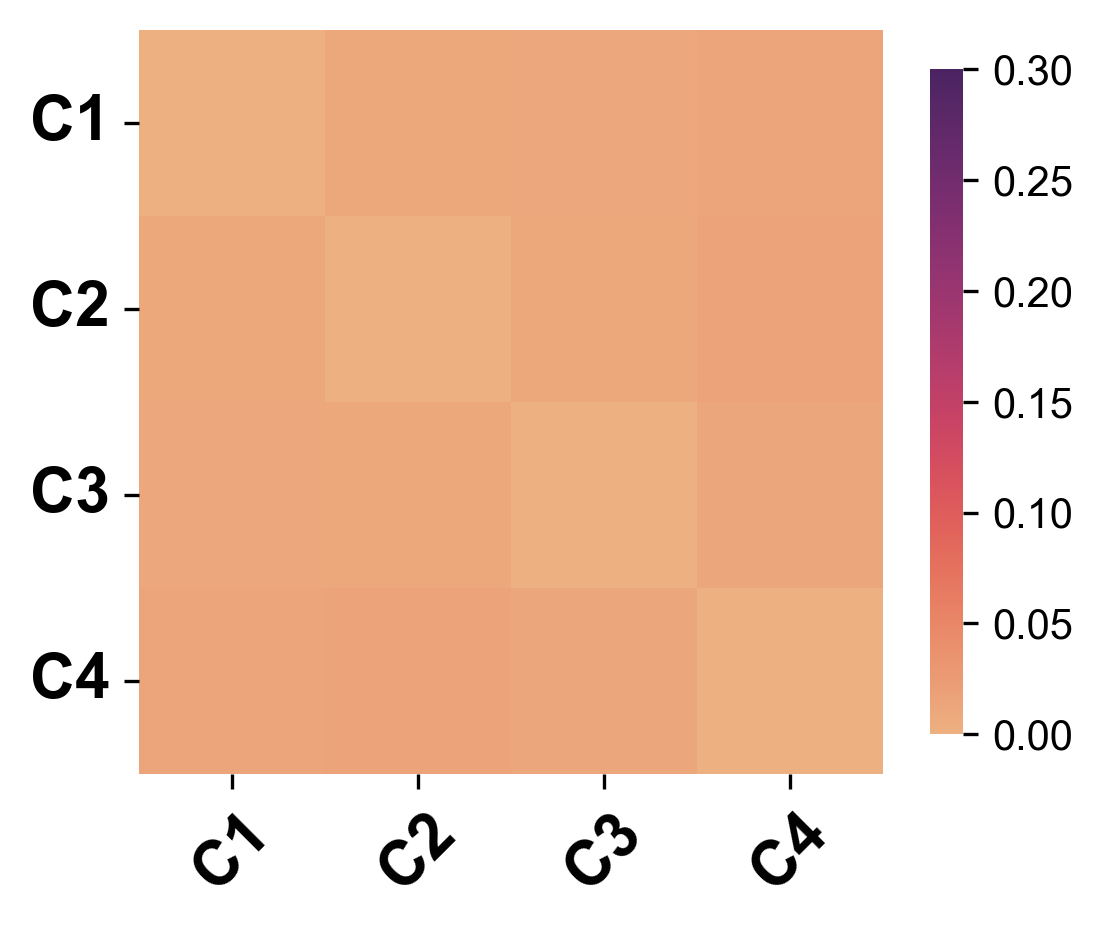

In [6]:
scenario_builder.visualize_data_heterogeneity(
    client_ids=[0, 1, 2, 3], 
    distance_method='swd',
    pca_col_threshold=20,
    fontsize=18,
    title=False,
    save_path='./plots/data_heterogeneity.svg'
)

### Missing Data Inspection


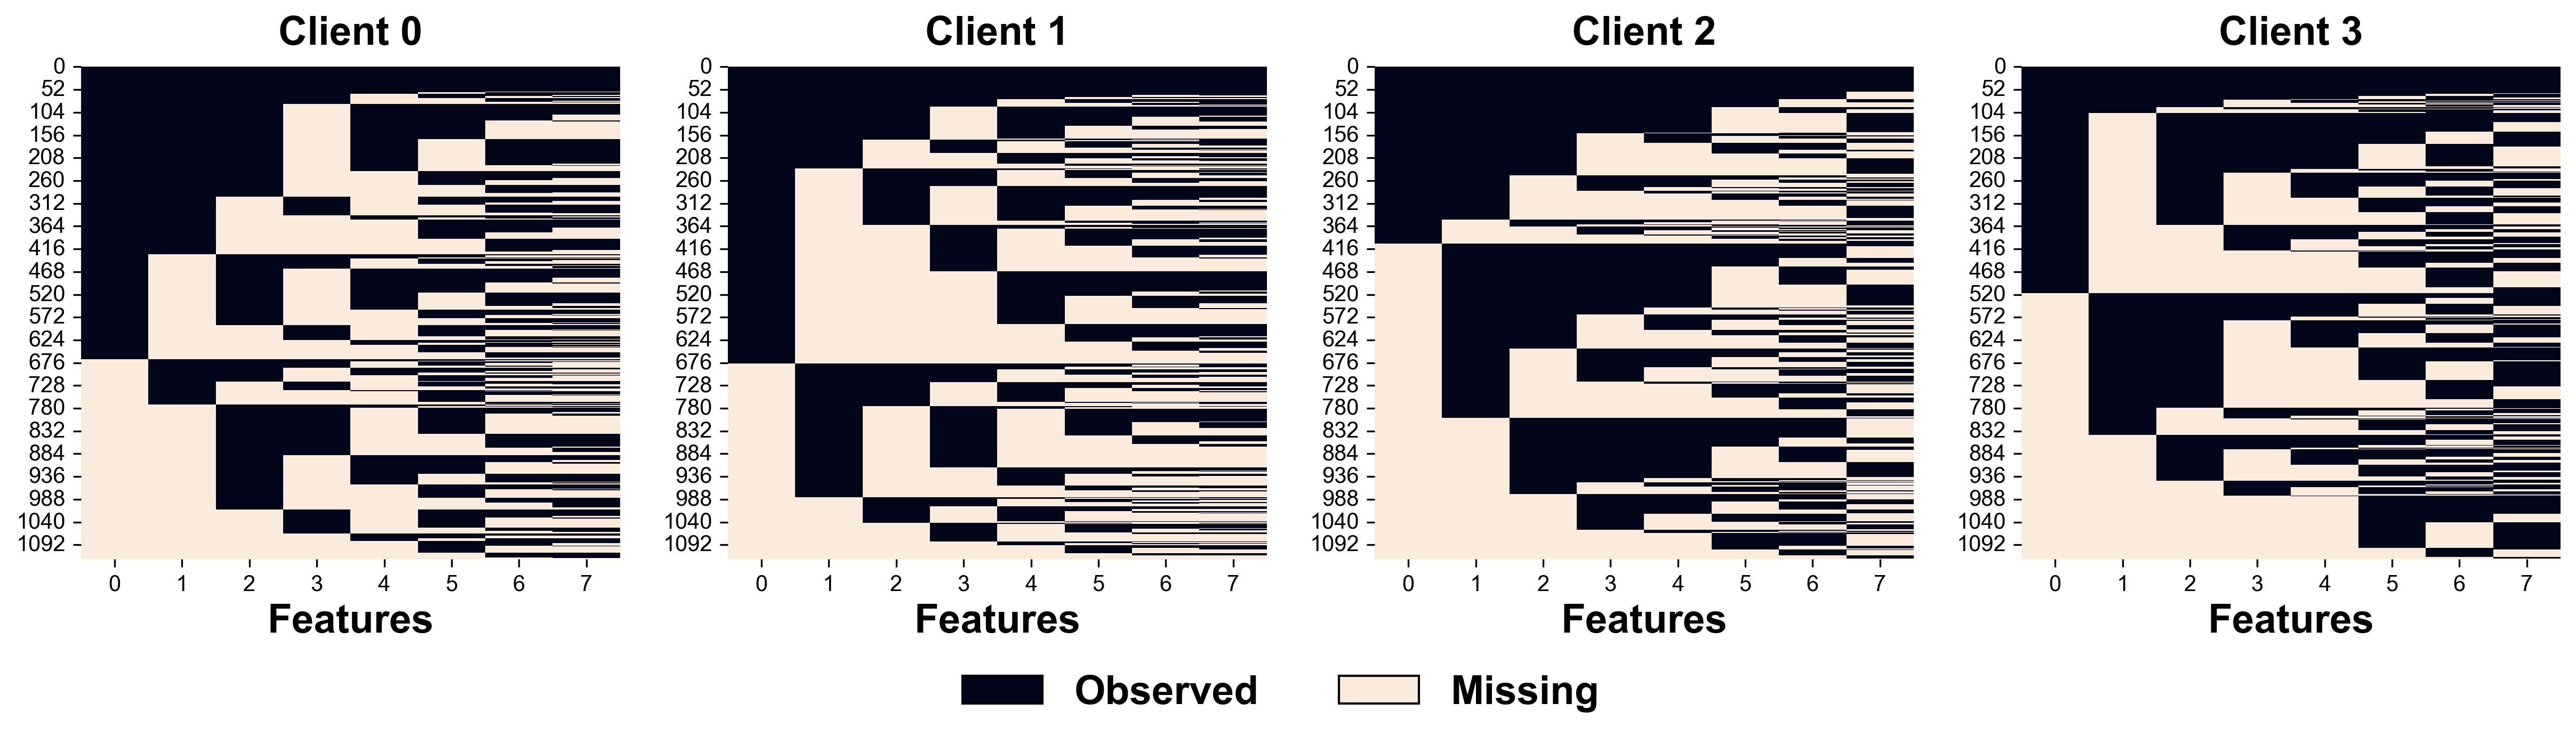

In [7]:
scenario_builder.visualize_missing_pattern(client_ids=[0, 1, 2, 3], save_path='./plots/ms_pattern.pdf')

In [8]:
scenario_builder.visualize_missing_distribution(
    client_ids = [0, 1], feature_ids = [0, 1, 2, 3, 4],
    stat = 'proportion', bins = 20, kde=True,
    save_path='./plots/ms_distribution.pdf'
)

# Running Federated Imputation

## Basic Usage

In [9]:
%load_ext autoreload
%autoreload 2
from fedimpute.execution_environment import FedImputeEnv

env = FedImputeEnv(debug_mode=False)
env.configuration(imputer = 'mice', fed_strategy='fedmice')
env.setup_from_scenario_builder(scenario_builder = scenario_builder, verbose=1)
env.show_env_info()
env.run_fed_imputation()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Setting up clients...
Setting up server...
Setting up workflow...
Environment setup complete.
Environment Information:
Workflow: ICE (Imputation via Chain Equation)
Clients:
 - Client 0: imputer: mice, fed-strategy: fedmice
 - Client 1: imputer: mice, fed-strategy: fedmice
 - Client 2: imputer: mice, fed-strategy: fedmice
 - Client 3: imputer: mice, fed-strategy: fedmice
Server: fed-strategy: fedmice



ICE Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

## Monitoring Imputation Progress


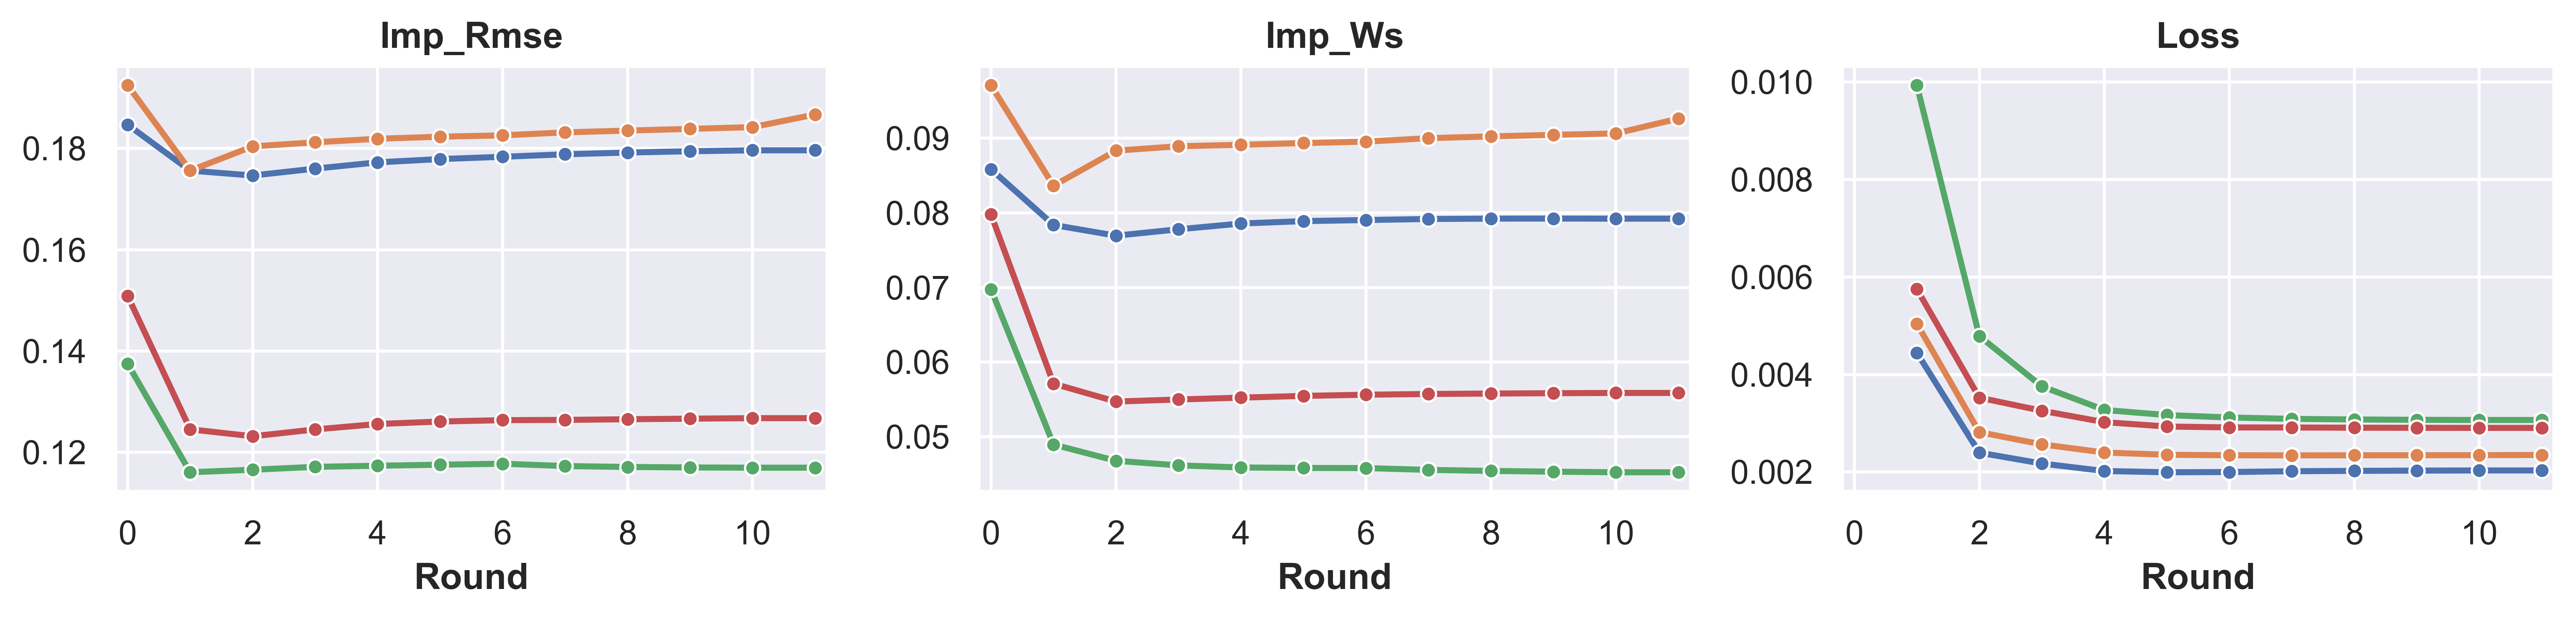

In [18]:
env.tracker.visualize_imputation_process()

# Evaluation

### Imputation Quality

In [20]:
%load_ext autoreload
%autoreload 2
from fedimpute.evaluation import Evaluator

X_trains = env.get_data(client_ids='all', data_type = 'train')
X_train_imps = env.get_data(client_ids='all', data_type = 'train_imp')
X_train_masks = env.get_data(client_ids='all', data_type = 'train_mask')

evaluator = Evaluator()
ret = evaluator.evaluate_imp_quality(
    X_train_imps = X_train_imps,
    X_train_origins = X_trains,
    X_train_masks = X_train_masks,
    metrics = ['rmse', 'nrmse', 'sliced-ws']
)
evaluator.show_imp_results()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Imputation Quality
               rmse       nrmse      sliced-ws
----------  ----------  ----------  -----------
 Client 1     0.172       0.480        0.076
 Client 2     0.184       0.534        0.090
 Client 3     0.120       0.332        0.047
 Client 4     0.128       0.359        0.058
----------  ----------  ----------  ----------
 Average      0.151       0.426        0.068
   Std        0.028       0.083        0.016


Evaluating TSNE for Client 1 ...
Evaluating TSNE for Client 2 ...
Evaluating TSNE for Client 3 ...
Evaluating TSNE for Client 4 ...


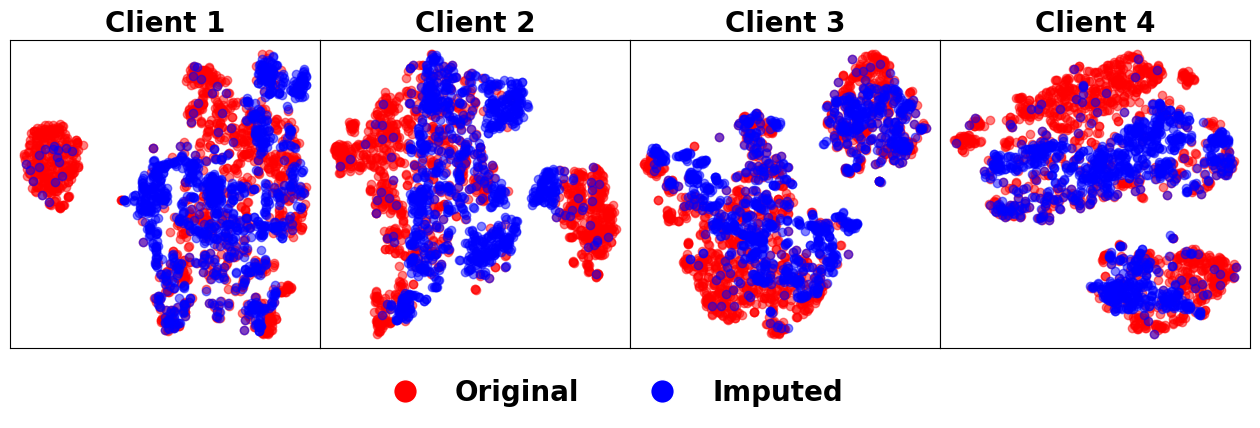

In [21]:
X_trains = env.get_data(client_ids='all', data_type = 'train')
X_train_imps = env.get_data(client_ids='all', data_type = 'train_imp')

evaluator.tsne_visualization(
    X_imps = X_train_imps,
    X_origins = X_trains,
    seed = 0
)

### Local Prediction

In [22]:
X_trains, y_trains = env.get_data(client_ids='all', data_type = 'train', include_y=True)
X_tests, y_tests = env.get_data(client_ids='all', data_type = 'test', include_y=True)
X_train_imps = env.get_data(client_ids='all', data_type = 'train_imp')
data_config = env.get_data(data_type = 'config')

ret = evaluator.evaluate_local_pred(
    X_train_imps = X_train_imps,
    X_train_origins = X_trains,
    y_trains = y_trains,
    X_tests = X_tests,
    y_tests = y_tests,
    data_config = data_config,
    model = 'nn',
    seed= 0
)
evaluator.show_local_pred_results()

Clients:   0%|          | 0/4 [00:00<?, ?it/s]

Early stopping at epoch 593
Early stopping at epoch 287
Early stopping at epoch 583
Early stopping at epoch 360
Downstream Prediction (Local)
             accuracy       f1         auc         prc
----------  ----------  ----------  ----------  ----------
 Client 1     0.788       0.636       0.861       0.741
 Client 2     0.894       0.824       0.953       0.935
 Client 3     0.929       0.895       0.976       0.969
 Client 4     0.752       0.481       0.854       0.760
----------  ----------  ----------  ----------  ----------
 Average      0.841       0.709       0.911       0.851
   Std        0.073       0.162       0.054       0.102


### Federated Prediction

In [23]:
X_train_imps = env.get_data(client_ids='all', data_type = 'train_imp')
X_trains, y_trains = env.get_data(
    client_ids='all', data_type = 'train', include_y=True
)
X_tests, y_tests = env.get_data(
    client_ids='all', data_type = 'test', include_y=True
)
X_global_test, y_global_test = env.get_data(
    data_type = 'global_test', include_y = True
)
data_config = env.get_data(data_type = 'config')

ret = evaluator.evaluate_fed_pred(
    X_train_imps = X_train_imps,
    X_train_origins = X_trains,
    y_trains = y_trains,
    X_tests = X_tests,
    y_tests = y_tests,
    X_test_global = X_global_test,
    y_test_global = y_global_test,
    data_config = data_config,
    train_params = {
        'global_epoch': 100,
        'local_epoch': 10,
        'fine_tune_epoch': 200,
    },
    seed= 0
)

evaluator.show_fed_pred_results()

Global Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 - average loss: 0.6716053117724026
Epoch 10 - average loss: 0.5709273157750859
Epoch 20 - average loss: 0.48411076998009406
Epoch 30 - average loss: 0.4436344894416192
Epoch 40 - average loss: 0.43356676005265293
Epoch 50 - average loss: 0.4266376635607551
Epoch 60 - average loss: 0.4221082873204175
Early stopping at epoch 65
Epoch 70 - average loss: 0.40617619396424764
Early stopping at epoch 71
Early stopping at epoch 74
Epoch 80 - average loss: 0.3788260501973769
Early stopping at epoch 81
Early stopping at epoch 100
Early stopping at epoch 121
Early stopping at epoch 125
Downstream Prediction (Fed)
 Personalized    accuracy       f1         auc         prc
--------------  ----------  ----------  ----------  ----------
   Client 1       0.885       0.831       0.958       0.900
   Client 2       0.920       0.883       0.982       0.956
   Client 3       0.885       0.835       0.975       0.951
   Client 4       0.867       0.819       0.973       0.961
  ----------    ----

### All In One

In [34]:
%load_ext autoreload
%autoreload 2
from fedimpute.evaluation import Evaluator

evaluator = Evaluator()
ret = evaluator.evaluate_all(
    env, metrics = ['imp_quality', 'pred_downstream_local', 'pred_downstream_fed']
)
evaluator.show_results_all()

Evaluating imputation quality...
Imputation quality evaluation completed.
Evaluating downstream prediction...


Clients:   0%|          | 0/4 [00:00<?, ?it/s]

Early stopping at epoch 593
Early stopping at epoch 287
Early stopping at epoch 583
Early stopping at epoch 360
Downstream prediction evaluation completed.
Evaluating federated downstream prediction...


Global Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 - average loss: 0.6716053117724026
Epoch 10 - average loss: 0.5709273157750859
Epoch 20 - average loss: 0.48411076998009406
Epoch 30 - average loss: 0.4436344894416192
Epoch 40 - average loss: 0.43356676005265293
Epoch 50 - average loss: 0.4266376635607551
Epoch 60 - average loss: 0.4221082873204175
Early stopping at epoch 65
Epoch 70 - average loss: 0.40617619396424764
Early stopping at epoch 71
Early stopping at epoch 74
Epoch 80 - average loss: 0.3788260501973769
Early stopping at epoch 81
Early stopping at epoch 100
Early stopping at epoch 121
Early stopping at epoch 125
Federated downstream prediction evaluation completed.
Evaluation completed.


imp_quality                     pred_downstream_local                      \
         rmse     nrmse sliced-ws              accuracy        f1       auc   
0    0.172028  0.479522  0.075509              0.787611  0.636364  0.860953   
1    0.184269  0.533933  0.090226              0.893805  0.823529  0.952703   
2    0.119754  0.331969  0.047390              0.929204  0.894737  0.975818   
3    0.128211  0.359113  0.057849              0.752212  0.481481  0.854196   

              pred_downstream_fed                                   \
        prc personalized_accuracy personalized_f1 personalized_auc   
0  0.741470              0.884956        0.831169         0.958037   
1  0.934722              0.920354        0.883117         0.981508   
2  0.969489              0.884956        0.835443         0.975462   
3  0.760059              0.867257        0.819277         0.972617   

                                                                    
  personalized_prc global_accuracy global_f1 global_auc global_prc  
0         0.900117           0.906   0.86217   0.968807    0.94098  
1         0.956229           0.906   0.86217   0.968807    0.94098  
2         0.951035           0.906   0.86217   0.968807    0.94098  
3         0.961279           0.906   0.86217   0.968807    0.94098

### Export Evaluation Results in Different Format

In [26]:
evaluator.export_results(format = 'dataframe')

imp_quality                     pred_downstream_local                      \
         rmse     nrmse sliced-ws              accuracy        f1       auc   
0    0.172028  0.479522  0.075509              0.787611  0.636364  0.860953   
1    0.184269  0.533933  0.090226              0.893805  0.823529  0.952703   
2    0.119754  0.331969  0.047390              0.929204  0.894737  0.975818   
3    0.128211  0.359113  0.057849              0.752212  0.481481  0.854196   

              pred_downstream_fed                                   \
        prc personalized_accuracy personalized_f1 personalized_auc   
0  0.741470              0.884956        0.831169         0.958037   
1  0.934722              0.920354        0.883117         0.981508   
2  0.969489              0.884956        0.835443         0.975462   
3  0.760059              0.867257        0.819277         0.972617   

                                                                    
  personalized_prc global_accuracy global_f1 global_auc global_prc  
0         0.900117           0.906   0.86217   0.968807    0.94098  
1         0.956229           0.906   0.86217   0.968807    0.94098  
2         0.951035           0.906   0.86217   0.968807    0.94098  
3         0.961279           0.906   0.86217   0.968807    0.94098

In [29]:
ret = evaluator.export_results(format = 'dict-dataframe')
ret['imp_quality']

,rmse,nrmse,sliced-ws
0,0.172028,0.479522,0.075509
1,0.184269,0.533933,0.090226
2,0.119754,0.331969,0.047390
3,0.128211,0.359113,0.057849


In [32]:
ret = evaluator.export_results(format = 'dict-dataframe')
ret['pred_downstream_fed']

,personalized_accuracy,personalized_f1,personalized_auc,personalized_prc,global_accuracy,global_f1,global_auc,global_prc
0,0.884956,0.831169,0.958037,0.900117,0.906,0.86217,0.968807,0.94098
1,0.920354,0.883117,0.981508,0.956229,0.906,0.86217,0.968807,0.94098
2,0.884956,0.835443,0.975462,0.951035,0.906,0.86217,0.968807,0.94098
3,0.867257,0.819277,0.972617,0.961279,0.906,0.86217,0.968807,0.94098


# Benchmarking Pipeline

In [94]:
%load_ext autoreload
%autoreload 2
from fedimpute.pipeline import FedImputePipeline

pipeline = FedImputePipeline()
pipeline.setup(
    id = 'test_pipeline',
    fed_imp_configs = [
        ('em', ['local', 'fedem'], {}, [{}, {}]),
        ('mice', ['local', 'fedmice'], {}, [{}, {}]),
        ('gain', ['local', 'fedavg'], {}, [{}, {}]),
    ],
    persist_data = False,
    description = 'test'
)

pipeline.pipeline_setup_summary()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Experiment ID: test_pipeline
Description: test
Persist Data: False
Evaluation: ['imp_quality', 'local_pred', 'fed_pred']
Seed: 100330201
--------------------------------------------------------------
    Imputer    Fed Strategy    Imp Params    Strategy Params
--  ---------  --------------  ------------  -----------------
 0  em         local           {}            {}
 1  em         fedem           {}            {}
 2  mice       local           {}            {}
 3  mice       fedmice         {}            {}
 4  gain       local           {}            {}
 5  gain       fedavg          {}            {}



In [95]:
pipeline.run_pipeline(
    simulator, repeats = 1, verbose = 1
)

----------------------------------------------------------------------------------------------------
Running experiment: 1 / 6
Imputer: em | Fed Strategy: local |Imp Params: {} | Strategy Params: {}
Imputation Start ...
Initial: rmse - 0.2602 ws - 0.1349


Clients:   0%|          | 0/4 [00:00<?, ?it/s]

EM converged after 3 iterations.
EM converged after 2 iterations.
EM converged after 3 iterations.
EM converged after 4 iterations.
Final: rmse - 0.2505 ws - 0.1289
Running time: 2.6570 seconds


Clients:   0%|          | 0/4 [00:00<?, ?it/s]

Early stopping at epoch 428
Early stopping at epoch 309
Early stopping at epoch 576
Early stopping at epoch 243


Global Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 - average loss: 0.6852318048477173
Epoch 10 - average loss: 0.6026552538661396
Epoch 20 - average loss: 0.5766739832127796
Epoch 30 - average loss: 0.5591664016246796
Epoch 40 - average loss: 0.5472374050056232
Epoch 50 - average loss: 0.5470328948953572
Early stopping at epoch 58
Epoch 60 - average loss: 0.5348919396306954
Epoch 70 - average loss: 0.5332270299687104
Early stopping at epoch 71
Early stopping at epoch 72
Epoch 80 - average loss: 0.5302949845790863
Early stopping at epoch 88
Early stopping at epoch 188
Early stopping at epoch 197
Early stopping at epoch 151
----------------------------------------------------------------------------------------------------
Running experiment: 2 / 6
Imputer: em | Fed Strategy: fedem |Imp Params: {} | Strategy Params: {}
Imputation Start ...
Initial: rmse - 0.1832 ws - 0.0911


Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0: rmse - 0.1561 ws - 0.0746
Epoch 1: rmse - 0.1513 ws - 0.0695
Epoch 2: rmse - 0.1490 ws - 0.0670
Epoch 3: rmse - 0.1477 ws - 0.0656
Epoch 4: rmse - 0.1470 ws - 0.0648
Epoch 5: rmse - 0.1465 ws - 0.0642
Epoch 6: rmse - 0.1462 ws - 0.0639
Epoch 7: rmse - 0.1462 ws - 0.0638
All clients converged, iteration 8
Final: rmse - 0.1462 ws - 0.0638
Running time: 10.0379 seconds


Clients:   0%|          | 0/4 [00:00<?, ?it/s]

Early stopping at epoch 596
Early stopping at epoch 540
Early stopping at epoch 635
Early stopping at epoch 342


Global Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 - average loss: 0.6680521088487962
Epoch 10 - average loss: 0.5459251565968289
Epoch 20 - average loss: 0.49220619745114275
Epoch 30 - average loss: 0.4334482230684336
Epoch 40 - average loss: 0.4074271807775778
Epoch 50 - average loss: 0.40386741827515993
Early stopping at epoch 56
Epoch 60 - average loss: 0.39442776698692167
Early stopping at epoch 61
Early stopping at epoch 61
Epoch 70 - average loss: 0.3848865417873158
Early stopping at epoch 73
Early stopping at epoch 137
Early stopping at epoch 77
Early stopping at epoch 52
----------------------------------------------------------------------------------------------------
Running experiment: 3 / 6
Imputer: mice | Fed Strategy: local |Imp Params: {} | Strategy Params: {}
Imputation Start ...
Initial: rmse - 0.2602 ws - 0.1349


ICE Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 0: rmse - 0.2499 ws - 0.1279


Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1: rmse - 0.2433 ws - 0.1230


Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2: rmse - 0.2388 ws - 0.1194


Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3: rmse - 0.2381 ws - 0.1184


Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4: rmse - 0.2373 ws - 0.1176


Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5: rmse - 0.2368 ws - 0.1170


Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6: rmse - 0.2363 ws - 0.1165


Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7: rmse - 0.2359 ws - 0.1161


Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8: rmse - 0.2357 ws - 0.1160


Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9: rmse - 0.2356 ws - 0.1159
All clients converged, iteration 9
Final: rmse - 0.2356 ws - 0.1159
Running time: 6.4386 seconds


Clients:   0%|          | 0/4 [00:00<?, ?it/s]

Early stopping at epoch 494
Early stopping at epoch 243
Early stopping at epoch 518
Early stopping at epoch 162


Global Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 - average loss: 0.6858881212332669
Epoch 10 - average loss: 0.5965307898381177
Epoch 20 - average loss: 0.5716207185212303
Epoch 30 - average loss: 0.558542685911936
Epoch 40 - average loss: 0.5497896000742912
Epoch 50 - average loss: 0.5480287592200672
Early stopping at epoch 58
Epoch 60 - average loss: 0.5366446118728788
Epoch 70 - average loss: 0.5367836806119657
Early stopping at epoch 72
Epoch 80 - average loss: 0.529742247041534
Early stopping at epoch 89
Epoch 90 - average loss: 0.5179214705439175
Early stopping at epoch 90
Early stopping at epoch 127
----------------------------------------------------------------------------------------------------
Running experiment: 4 / 6
Imputer: mice | Fed Strategy: fedmice |Imp Params: {} | Strategy Params: {}
Imputation Start ...
Initial: rmse - 0.1832 ws - 0.0911


ICE Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 0: rmse - 0.1520 ws - 0.0699


Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1: rmse - 0.1502 ws - 0.0679


Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2: rmse - 0.1500 ws - 0.0675


Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3: rmse - 0.1500 ws - 0.0674


Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4: rmse - 0.1502 ws - 0.0674


Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5: rmse - 0.1502 ws - 0.0675


Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6: rmse - 0.1502 ws - 0.0674


Feature_idx:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7: rmse - 0.1511 ws - 0.0677
All clients converged, iteration 7
Final: rmse - 0.1511 ws - 0.0677
Running time: 5.3013 seconds


Clients:   0%|          | 0/4 [00:00<?, ?it/s]

Early stopping at epoch 651
Early stopping at epoch 425
Early stopping at epoch 509
Early stopping at epoch 378


Global Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 - average loss: 0.6697010529391907
Epoch 10 - average loss: 0.5561447463491384
Epoch 20 - average loss: 0.4944189243456897
Epoch 30 - average loss: 0.4401443280717906
Epoch 40 - average loss: 0.41360662526944103
Epoch 50 - average loss: 0.4085833233068971
Early stopping at epoch 56
Epoch 60 - average loss: 0.3923953058672886
Early stopping at epoch 61
Epoch 70 - average loss: 0.3683767879710478
Early stopping at epoch 72
Early stopping at epoch 78
Early stopping at epoch 134
Early stopping at epoch 116
Early stopping at epoch 68
----------------------------------------------------------------------------------------------------
Running experiment: 5 / 6
Imputer: gain | Fed Strategy: local |Imp Params: {} | Strategy Params: {}
Imputation Start ...
Initial: rmse - 0.5227 ws - 0.2964


Global Epoch:   0%|          | 0/300 [00:00<?, ?it/s]


Loss: 0.9227 (0.030994)

Loss: 0.7765 (0.024621)

Loss: 0.7120 (0.036262)

Loss: 0.6754 (0.041985)

Loss: 0.6509 (0.043503)

Loss: 0.6347 (0.043024)

Loss: 0.6233 (0.041136)

Loss: 0.6156 (0.040225)

Loss: 0.6076 (0.039028)

Loss: 0.6043 (0.037397)

Loss: 0.6023 (0.037439)

Loss: 0.6000 (0.037890)
All clients have converged. Stopping training at 114.
start fine tuning ...


Fine Tuning Epoch: 0it [00:00, ?it/s]

Final: rmse - 0.2599 ws - 0.1208
Running time: 99.3960 seconds


Clients:   0%|          | 0/4 [00:00<?, ?it/s]

Early stopping at epoch 680
Early stopping at epoch 365
Early stopping at epoch 377
Early stopping at epoch 638


Global Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 - average loss: 0.6730961957398583
Epoch 10 - average loss: 0.5978400663417929
Epoch 20 - average loss: 0.5800157938809956
Epoch 30 - average loss: 0.5666844884262365
Epoch 40 - average loss: 0.5555288638262188
Epoch 50 - average loss: 0.5373793121646433
Epoch 60 - average loss: 0.5218750028049244
Epoch 70 - average loss: 0.50243169200771
Epoch 80 - average loss: 0.487292159567861
Epoch 90 - average loss: 0.4765385183341363
Early stopping at epoch 80
Early stopping at epoch 187
Early stopping at epoch 148
----------------------------------------------------------------------------------------------------
Running experiment: 6 / 6
Imputer: gain | Fed Strategy: fedavg |Imp Params: {} | Strategy Params: {}
Imputation Start ...
Initial: rmse - 0.5227 ws - 0.2964


Global Epoch:   0%|          | 0/300 [00:00<?, ?it/s]


Loss: 0.9227 (0.030994)

Loss: 0.7917 (0.072330)

Loss: 0.7753 (0.067716)

Loss: 0.7615 (0.063676)

Loss: 0.7482 (0.060218)

Loss: 0.7412 (0.056916)

Loss: 0.7409 (0.056230)

Loss: 0.7415 (0.056552)
All clients have converged. Stopping training at 74.
start fine tuning ...


Fine Tuning Epoch: 0it [00:00, ?it/s]

Final: rmse - 0.2408 ws - 0.1066
Running time: 71.4822 seconds


Clients:   0%|          | 0/4 [00:00<?, ?it/s]

Early stopping at epoch 523
Early stopping at epoch 763
Early stopping at epoch 332
Early stopping at epoch 463


Global Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 - average loss: 0.6607095686828389
Epoch 10 - average loss: 0.5904788664158652
Early stopping at epoch 15
Epoch 20 - average loss: 0.5443049821199156
Epoch 30 - average loss: 0.5404780197377299
Early stopping at epoch 39
Epoch 40 - average loss: 0.507057719370898
Epoch 50 - average loss: 0.5046060856650857
Early stopping at epoch 57
Early stopping at epoch 59


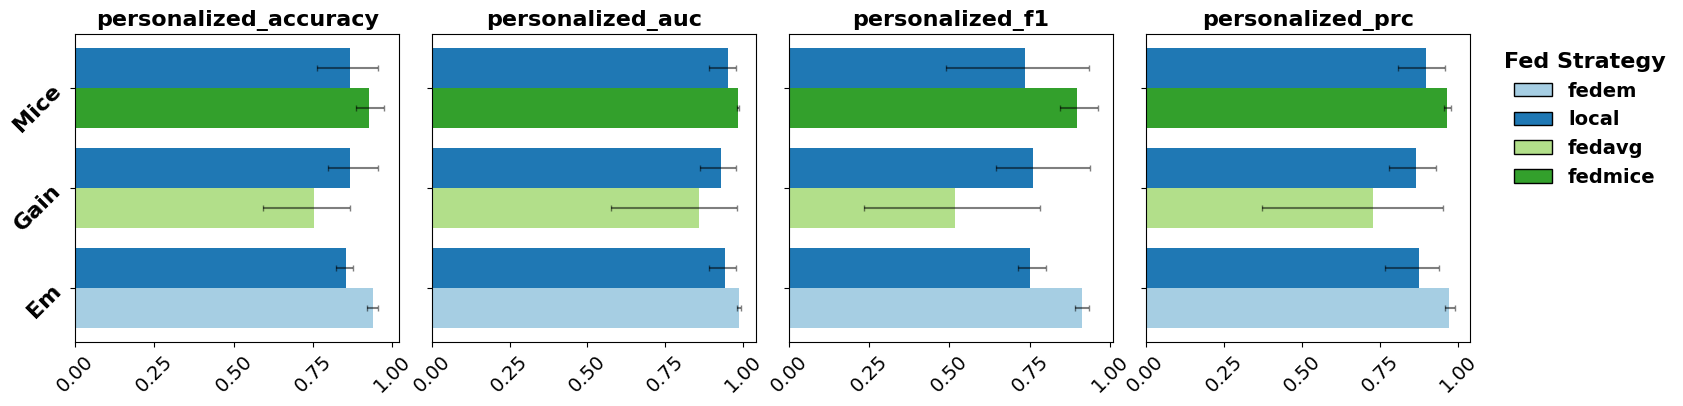

In [167]:
pipeline.plot_pipeline_results(
    metric_aspect = 'fed_pred_personalized',
    plot_type = 'bar',
)

In [193]:
data = pipeline.show_pipeline_results(
    format = 'dataframe',  
    metric_aspect = 'imp_quality',
    metric_name = 'rmse',
    show_round_variation = False
)
data